# Which Layers of SSD Predict Which Tags and Object Sizes?

### Setup and load model

In [1]:
# Set caffe root, label map, model definition, and model weights
#caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
caffe_root = '/home/youngwan/caffe/'
kitti_labelmap_file = 'data/kitti_ssd/labelmap_kitti.prototxt'
model_def = 'models/New/KITTI/inception_v3/SSD_Inception_v3_6_preActRes_basic_OriginASP_BN_cifar10_pretrained_300x300/test.prototxt'
model_weights = 'models/New/KITTI/inception_v3/SSD_Inception_v3_6_preActRes_basic_OriginASP_BN_cifar10_pretrained_300x300/KITTI_SSD_Inception_v3_6_preActRes_basic_OriginASP_BN_cifar10_pretrained_300x300_iter_60000.caffemodel'

# Set confidence threshold (0-1) for object detection
conf_thresh = 0.6

# Set number of images to search through. Max for VOC0712 is 4952
max_images = 4952

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
file = open(kitti_labelmap_file, 'r')
kitti_labelmap_file = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), kitti_labelmap_file)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([96,99,94])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

### Find layer that activates to each high confidence object in each image. Record details 

In [2]:
# keep track of the following
labels = []    # object label
heights = []   # object height (fraction of image height)
widths = []    # object width (fraction of image width)
layers = []    # network layer that found object with high confidence

# iterate through each image
for i in range(0, max_images + 1):
    net.forward()
    
    detections = net.blobs['detection_out'].data
    
    # Parse the outputs.
    det_label = detections[0,0,:,1]
    det_conf = detections[0,0,:,2]
    det_xmin = detections[0,0,:,3]
    det_ymin = detections[0,0,:,4]
    det_xmax = detections[0,0,:,5]
    det_ymax = detections[0,0,:,6]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= conf_thresh]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_labels = get_labelname(kitti_labelmap_file, top_label_indices)
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    
    if top_conf.size == 0:
        continue
        
    # iterate through each confident label found by SSD
    for k in range(0,top_conf.size):
        top_conf_k = top_conf[k]
        
        # find index of this confidence in output of mbox_conf_softmax
        conf_softmax = net.blobs['mbox_conf_softmax'].data
        tconf_softmax_idx = np.where(conf_softmax == top_conf_k)

        # use index from  mbox_conf_softmax to find value in mbox_conf_reshape
        conf_reshape = net.blobs['mbox_conf_reshape'].data
        tconf_reshape = conf_reshape[tconf_softmax_idx[0], tconf_softmax_idx[1], tconf_softmax_idx[2]]

        # use value from mbox_conf_reshape to find input layer (after perm) and index of layer
        conv_layers = ["bn4a_root_relu_norm_mbox_conf_perm", "bn_res4b_relu_mbox_conf_perm", "conv6_2_mbox_conf_perm", "conv7_2_mbox_conf_perm", "conv8_2_mbox_conf_perm",  "pool6_mbox_conf_perm"]

        for layer in conv_layers:
            layer_data = net.blobs[layer].data
            if tconf_reshape in layer_data:
                conf_perm_name = layer
                layers.append(layer[:-15])
                
                width = top_xmax[k] - top_xmin[k]
                height = top_ymax[k] - top_ymin[k]

                widths.append(width)
                heights.append(height)
                labels.append(top_labels[k])

/home/youngwan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


### Summarize detecting layers and labels detected

In [3]:
layer_counts = dict((x, layers.count(x)) for x in layers)
layer_dict = dict((x, i) for i, x in enumerate(layer_counts))

print "Layer Counts", str(layer_counts)
print
label_counts = dict((str(x), labels.count(x)) for x in labels)
label_dict = dict((x, i) for i, x in enumerate(label_counts))
print "Label Counts", str(label_counts)

# create 2d array with which to make a label/layer heat map
heat_map = np.zeros((len(label_counts), len(layer_counts)))

for i in range(0, len(layers)):
    lab_idx = label_dict.get(labels[i])
    lay_idx = layer_dict.get(layers[i])
    heat_map[lab_idx, lay_idx] += 1.0 / label_counts.get(labels[i])

Layer Counts {'conv6_2': 3875, 'conv7_2': 276, 'conv8_2': 204, 'bn4a_root_relu_norm': 25132, 'bn_res4b_relu': 9624}

Label Counts {'Cyclist': 1277, 'Van': 3002, 'Tram': 534, 'Car': 26529, 'Misc': 858, 'Pedestrian': 3050, 'Truck': 1435, 'Person_sitting': 84, 'DontCare': 2342}


### Produce heatmap of Layers vs Labels. Labels are each normalized by total count of that label

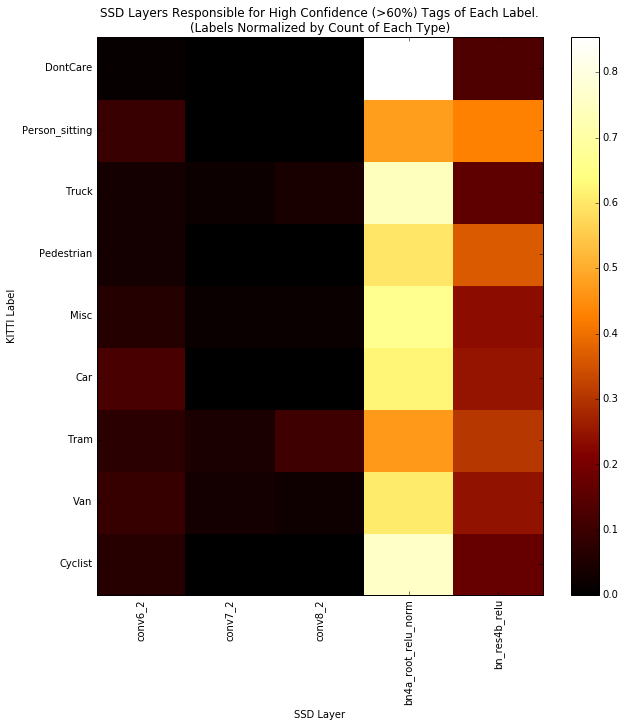

In [10]:
plt.pcolor(heat_map, cmap='afmhot') #YlOrRd
plt.colorbar()

label_val_shift = [x + 0.5 for x in label_dict.values()]
layer_val_shift = [x + 0.5 for x in layer_dict.values()]

plt.title("SSD Layers Responsible for High Confidence (>60%) Tags of Each Label.\n(Labels Normalized by Count of Each Type)")
plt.xlabel("SSD Layer")
plt.ylabel("KITTI Label")
plt.yticks(label_val_shift, label_dict.keys())
plt.xticks(layer_val_shift, layer_dict.keys(), rotation='vertical')
plt.savefig('jobs/figures/SSD Layers Responsibility.png')
plt.show()


### Produce heatmap of Layers vs Object Size

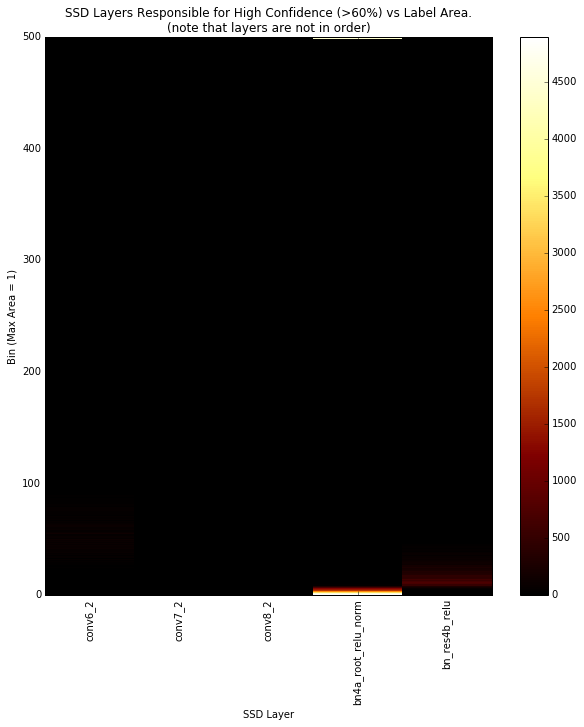

In [11]:
# calculate "area" of each object. Image sizes unknown here.
areas = []
for i in range(0, len(widths)):
    areas.append(widths[i] * heights[i])
    
# create 2d array with which to make a label/layer heat map
k = 500 # number of bins
heat_map_area = np.zeros((k, len(layer_counts)))

for i in range(0, len(areas)):
    area_idx = int(areas[i] * k) - 1
    lay_idx = layer_dict.get(layers[i])
    heat_map_area[area_idx, lay_idx] += 1.0
    
plt.pcolor(heat_map_area, cmap='afmhot')
plt.colorbar()

# label_val_shift = [x + 0.5 for x in label_dict.values()]
layer_val_shift = [x + 0.5 for x in layer_dict.values()]

plt.title("SSD Layers Responsible for High Confidence (>60%) vs Label Area.\n(note that layers are not in order)")
plt.xlabel("SSD Layer")
plt.ylabel("Bin (Max Area = 1)")
# plt.yticks(label_val_shift, label_dict.keys())
plt.xticks(layer_val_shift, layer_dict.keys(), rotation='vertical')
plt.savefig('jobs/figures/SSD Layers Responsibility2.png')
plt.show()